# **Preprocessing and Feature Selection of scRNA-Seq Data**

We first need to import relevant modules.

In [2]:
import numpy as np
import pandas as pd
import nvr
import matplotlib.pyplot as plt
%matplotlib inline

Next, upload UMI/counts from the data directory into a pandas Dataframe. This data is from mouse colon and has been reduced for computational time purposes, but steps outlined will be the same for full data sets.

In [3]:
counts = pd.read_csv( "../data/raw_scRNA.csv")

Its always a good idea to check that your data has been loaded correctly.

In [4]:
counts.head()

,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
0,0,4,4,0,0,0,1,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,0,8,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4,3,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
num_cells, num_genes = counts.shape
print( "Number of cells = {0}...........Number of genes = {1}".format( num_cells, num_genes))

Number of cells = 3000...........Number of genes = 38487


## **Filter Cells Based on Library Size**

Retrieve gene names for filtering

Calculate the library size (total number of counts) for all cells and sort the sizes from highest to lowest.

In [6]:
lib_sizes = np.sort( np.sum( counts.values, axis=1))[::-1] # [::-1] reverses the array order so that its highest to lowest

A histogram of library sizes shows that most of these cells have very few gene counts, so we to remove the cells with very few counts.

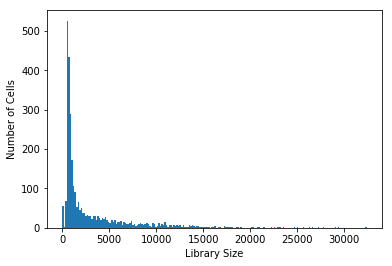

In [7]:
plt.hist( lib_sizes, bins=200)
plt.ylabel('Number of Cells')
_ = plt.xlabel('Library Size')

There are a few ways to accomplish this, but we prefer cumulative sum plotting. We start by first plotting the cumulative sum of the sorted cell library sizes, where cumulative sum of an *`array(a,b,c)`* equals *`(a, a+b, a+b+c)`*. We sorted or library sizes highest to lowest, so in our case *`a>b>c`*.

In [8]:
# simple example of np.cumsum()
np.cumsum( [6,4,1])

array([ 6, 10, 11])

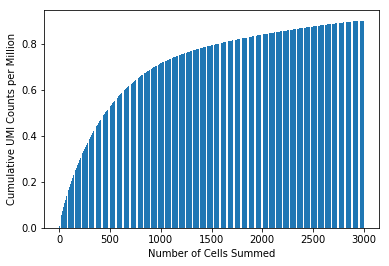

In [9]:
plt.bar( np.arange( num_cells), np.cumsum( lib_sizes)/1e7)
plt.ylabel( 'Cumulative UMI Counts per Million')
_ = plt.xlabel( 'Number of Cells Summed')

Cells with smaller library sizes will contribute less to the cumulative sum than cells with larger library sizes. Cells after the inflection point are considered "bad" due to their small library sizes. This cutoff changes dataset to dataset depending upon the platform, sequencing dept, biology, and etc.

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'xkcd', u'Humor Sans', u'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


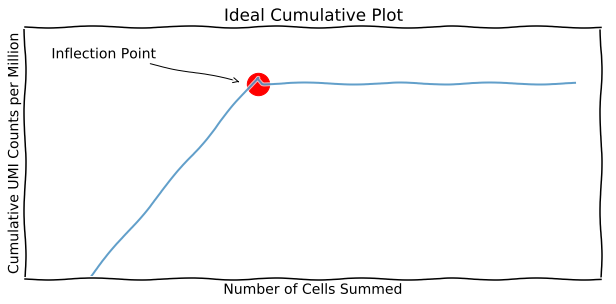

In [10]:
with plt.xkcd():
    fig = plt.figure( figsize=(10,5))
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    plt.xticks([])
    plt.yticks([])
    ax.set_ylim([-30, 10])
    data = np.ones(100) 
    data[:40] -= np.arange(40)[::-1] - 1
    plt.annotate( 'Inflection Point', xy=(36, 1.2), arrowprops=dict(arrowstyle='->'), xytext=(-0, 5))
    plt.plot(data, alpha=0.7)
    plt.scatter( 39, 1, c='red', s=500)
    plt.xlabel('Number of Cells Summed')
    plt.ylabel('Cumulative UMI Counts per Million')
    plt.title('Ideal Cumulative Plot')

Yes, this is very much a subjectively set threshold. For that reason, we like to under estimate the inflection point to be more restrictive. Here, we estimate it to be ~900.

In [11]:
inflect_pt = 900

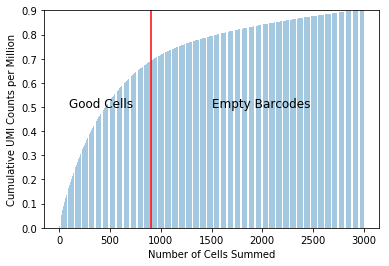

In [12]:
plt.bar( np.arange( num_cells), np.cumsum( lib_sizes)/1e7, alpha=0.4)
plt.vlines( inflect_pt, 0, 0.9, colors='red')
plt.ylabel( 'Cumulative UMI Counts per Million')
plt.text( 100, 0.5, 'Good Cells', fontsize=12)
plt.text( 1500, 0.5, 'Empty Barcodes', fontsize=12)
plt.ylim(0.0,0.9)
_ = plt.xlabel( 'Number of Cells Summed')

Good cells can now be selected for using our threshold. Since the library sizes were sorted from high to low we can pull the 900 cells with largest cell libraries using the `np.argsort()` function. Instead of returning the sorted values, `np.argsort()` returns an array of element indices that have been sorted on  values from lowest to highest.  

In [13]:
# simple np.argsort() example
np.argsort( [5,1,2])

array([1, 2, 0])

In [14]:
np.argsort( lib_sizes)

array([2999, 2998, 2997, ...,    2,    1,    0])

Sort functions rank from lowest to highest so we want the last 900 cell indices.

In [15]:
good_ind = np.argsort( lib_sizes)[-inflect_pt:]

Select good cells from raw count data. 

In [16]:
good_cells = counts.iloc[good_ind,:]
good_cells.head()

,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
good_cells.shape

(900, 38487)

## **Filter Genes**

To filter out genes we start by removing genes with only 0 or 1 as entry.

In [47]:
# for speed purposes create ndarray from good_cells Dataframe
good_vals = good_cells.values
# create an array to hold good gene indices
good_gene_ind = np.array( [], dtype=int)
for ii in range( num_genes):
    # get the unique values for column index ii
    unique_vals = np.unique( good_vals[:,ii])
    # test if the sum of unique values is less than or equal to 1
    if( unique_vals.sum()>1):
        # if so record the column index
        good_gene_ind = np.append( good_gene_ind, ii)

In [48]:
exp_genes = good_cells.iloc[:,good_gene_ind]
exp_genes.head()

,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,0610031O16Rik,...,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6,mt-Rnr1,mt-Rnr2
899,0,0,0,0,0,0,0,0,0,0,...,55,30,24,6,36,0,14,0,41,129
898,1,0,0,0,0,0,0,0,0,0,...,125,104,64,31,105,2,10,0,10,15
897,0,0,0,0,0,0,0,0,0,0,...,208,248,186,53,220,1,37,0,21,55
896,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
895,0,0,0,0,0,0,0,0,0,0,...,61,40,38,29,52,0,3,0,18,34


## **Remove Mitochondrial Genes**

In [49]:
exp_names = exp_genes.columns

Identify mitochondrial genes by searching for genes that start with 'mt'.

In [50]:
mt_mask = pd.Series( exp_names).str.startswith( 'mt').values
exp_names.values[mt_mask]

array(['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb',
       'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5',
       'mt-Nd6', 'mt-Rnr1', 'mt-Rnr2'], dtype=object)

We can invert the mask using `~`.

In [54]:
# example of inverting a mask
print  mt_mask
print ~mt_mask

[False False False ...  True  True  True]
[ True  True  True ... False False False]


In [51]:
exp_names.values[~mt_mask]

array(['0610007P14Rik', '0610009B22Rik', '0610009E02Rik', ..., 'Zzz3',
       'a', 'l7Rn6'], dtype=object)

We now have a Dataframe filtered by both cells and genes. 

In [53]:
filt_genes = exp_genes.iloc[:,~mt_mask]
filt_genes.head()

,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,0610031O16Rik,...,Zwilch,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Normalize for Cell Specific Biases**

In [23]:
reduced.to_csv( "/home/herrinca/workspace/Discovery_Oriented_Data_Science/Discovery_Oriented_Data_Science/data/raw_scRNA_reduced.csv", index=None)